In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import random
import pickle as pk
%matplotlib inline

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split


from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis, ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM, FastKernelSurvivalSVM

random_state = 12345
n_splits = 2
n_repeats = 10
    
with open(f"data/X_admissions_general_pp=(ohe_norm)_cf_pp=(bool).df", "rb") as f: 
    X = pk.load(f)
    
with open("data/y_admissions.df", "rb") as f: 
    df_y = pk.load(f)
    
y = np.array([(i,t) for i,t in zip(df_y["Ingreso"], df_y["t"])], dtype=[('Ingreso','?'), ('t', '<f8')])

In [27]:
feature_names = list(X.columns)

feature_importance = dict()

## Ridge Cox

In [28]:
gcv = pk.load(open('results/tuned_params_model=(ridge_cox)_general_pp=(ohe_norm)_cf_pp=(bool).pk', 'rb'))

alphas = []
for g in gcv: 
    alphas.append(g.best_params_['alpha'])

print(f'Mean best alpha: {np.mean(alphas)}')

Mean best alpha: 5.6638546037838315


In [29]:
#re-train with all instances and best params 
model = CoxPHSurvivalAnalysis(n_iter=100000, alpha=np.mean(alphas))
model.fit(X, y)

CoxPHSurvivalAnalysis(alpha=5.6638546037838315, n_iter=100000)

Number of non-zero coefficients: 76


/tmp/ipykernel_556156/210285433.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero_coefs['feature'] = non_zero_coefs.index


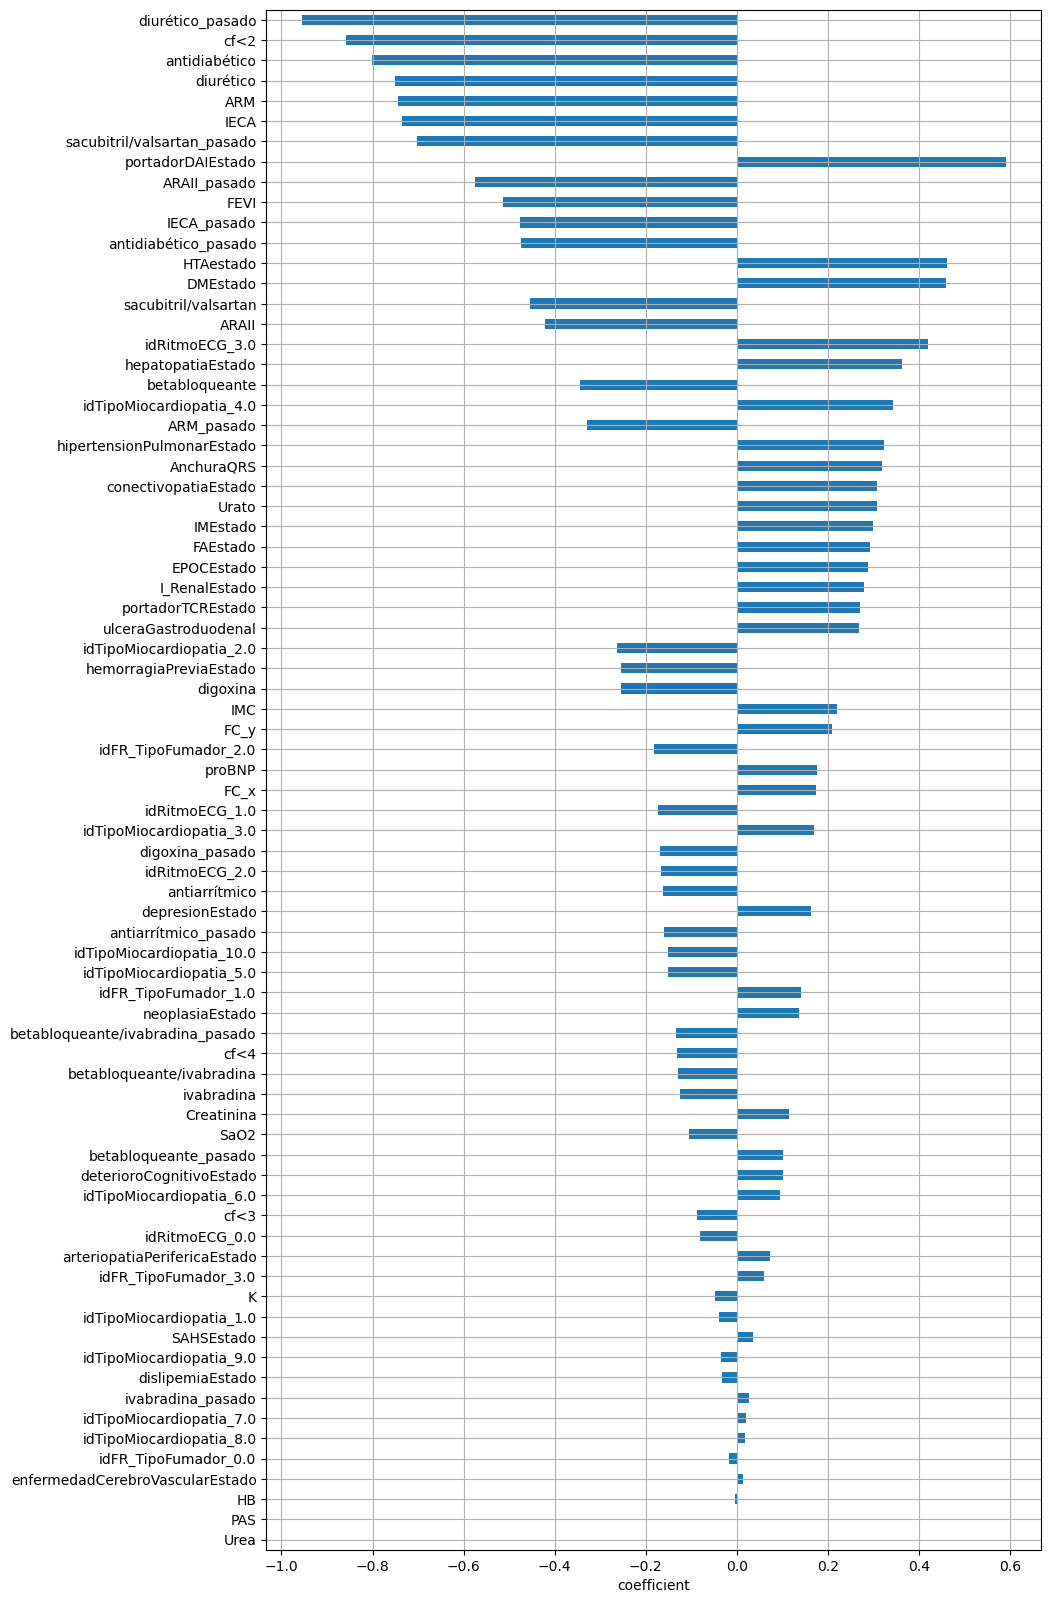

In [30]:
best_coefs = pd.DataFrame(model.coef_, index=X.columns, columns=['coefficient'])

non_zero = np.sum(best_coefs.iloc[:,0] != 0)
print(f'Number of non-zero coefficients: {non_zero}')

non_zero_coefs = best_coefs.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').index

non_zero_coefs['feature'] = non_zero_coefs.index
aux = []
for index, row in non_zero_coefs.iterrows(): 
    aux.append((row['feature'], row['coefficient']))
feature_importance['CoxPHSurvivalAnalysis'] = aux

fig, ax = plt.subplots(figsize=(10,20))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

Number of non-zero coefficients: 76


/tmp/ipykernel_556156/1212685369.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero_coefs['feature'] = non_zero_coefs.index


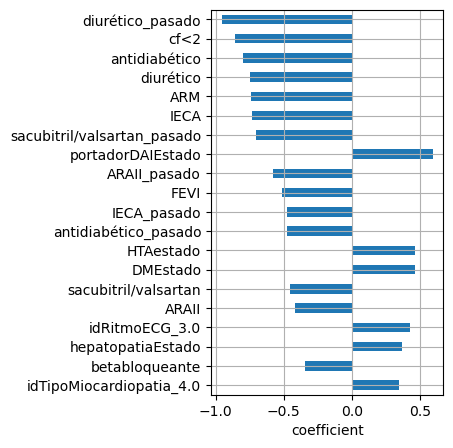

In [33]:
best_coefs = pd.DataFrame(model.coef_, index=X.columns, columns=['coefficient'])

non_zero = np.sum(best_coefs.iloc[:,0] != 0)
print(f'Number of non-zero coefficients: {non_zero}')

non_zero_coefs = best_coefs.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').index[-20:]

non_zero_coefs['feature'] = non_zero_coefs.index
aux = []
for index, row in non_zero_coefs.iterrows(): 
    aux.append((row['feature'], row['coefficient']))
feature_importance['CoxPHSurvivalAnalysis'] = aux

fig, ax = plt.subplots(figsize=(3,5))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

## Elastic net Cox

In [34]:
gcv = pk.load(open('results/tuned_params_model=(elastic_net_cox)_general_pp=(ohe_norm)_cf_pp=(bool).pk', 'rb'))

l1_ratios = []
for g in gcv: 
    l1_ratios.append(g.best_params_['l1_ratio'])

print(f'Mean best l1_ratio: {np.mean(l1_ratios)}')

Mean best l1_ratio: 0.10000000000000002


In [35]:
#re-train with all instances and best params 
model = CoxnetSurvivalAnalysis(alphas=None, fit_baseline_model=True, l1_ratio=np.mean(l1_ratios))
model.fit(X, y)

CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=0.10000000000000002)

coefficient


/tmp/ipykernel_556156/2857554480.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero_coefs['feature'] = non_zero_coefs.index


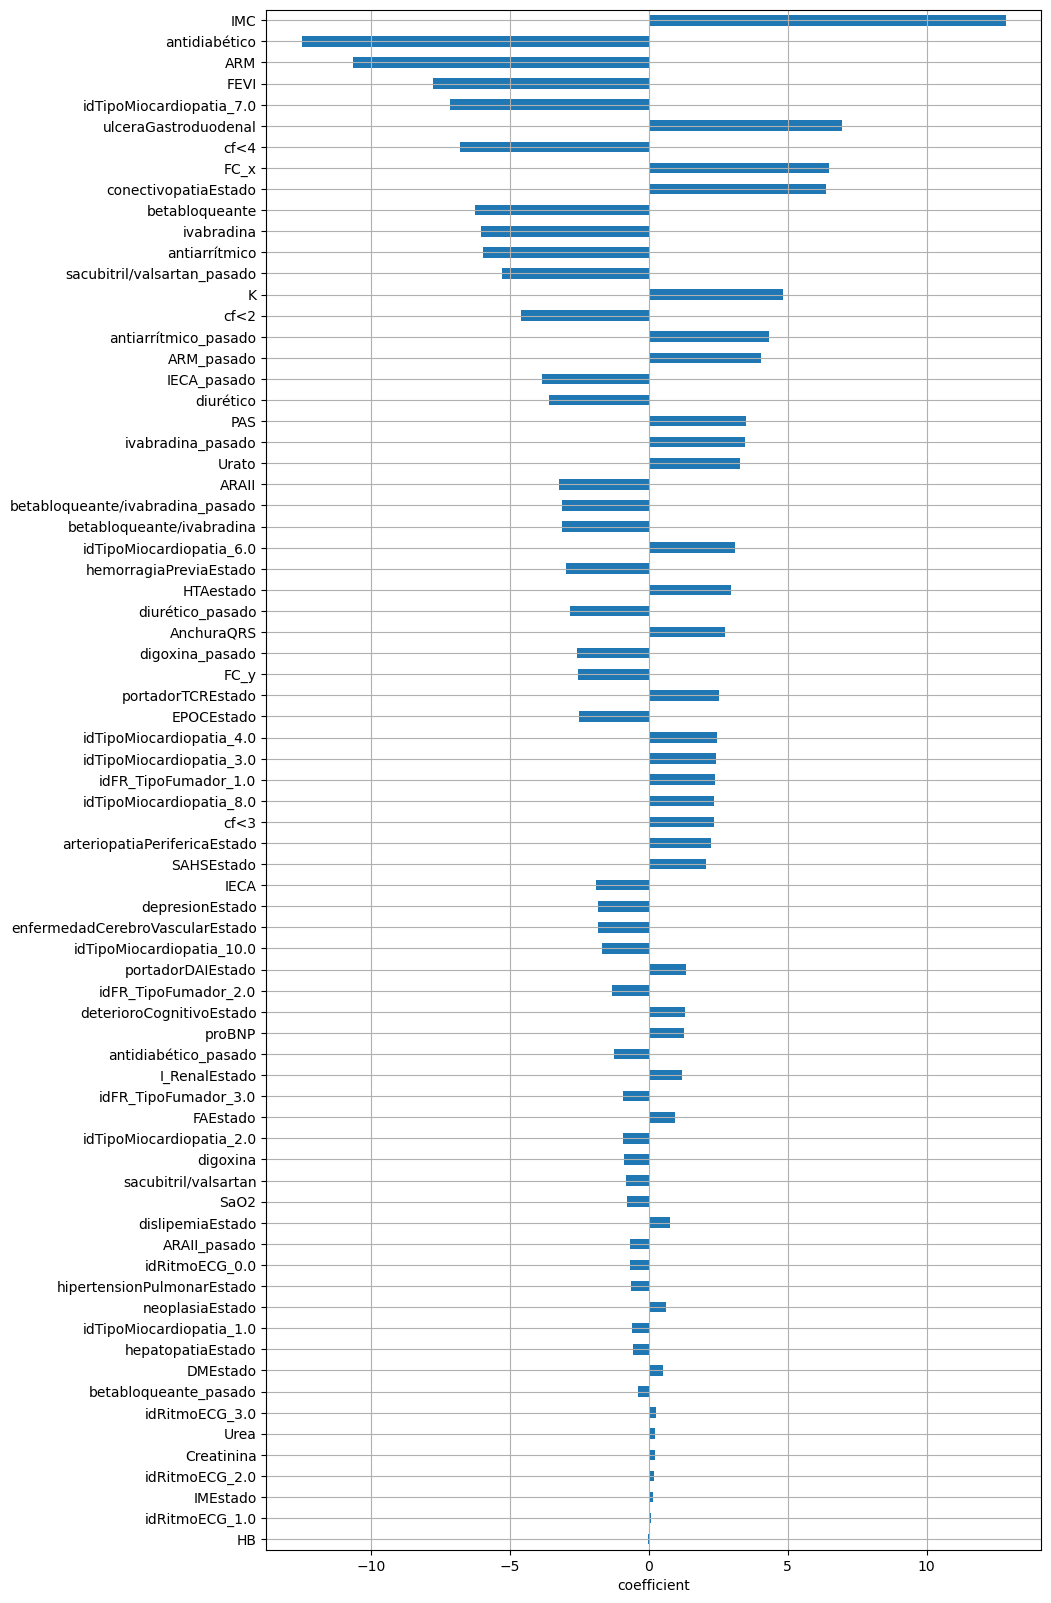

In [36]:
best_coefs = pd.DataFrame(model.coef_[:, -1], index=X.columns, columns=['coefficient'])

for alpha in best_coefs.columns: 
    print(alpha)
non_zero_coefs = best_coefs.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').index

non_zero_coefs['feature'] = non_zero_coefs.index
aux = []
for index, row in non_zero_coefs.iterrows(): 
    aux.append((row['feature'], row['coefficient']))
feature_importance['CoxnetSurvivalAnalysis'] = aux

fig, ax = plt.subplots(figsize=(10,20))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

coefficient


/tmp/ipykernel_556156/453234749.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero_coefs['feature'] = non_zero_coefs.index


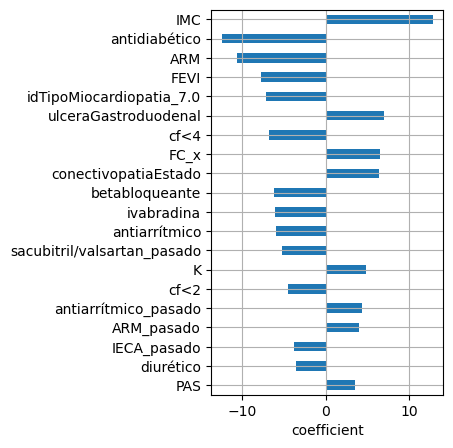

In [37]:
best_coefs = pd.DataFrame(model.coef_[:, -1], index=X.columns, columns=['coefficient'])

for alpha in best_coefs.columns: 
    print(alpha)
non_zero_coefs = best_coefs.query('coefficient != 0')
coef_order = list(non_zero_coefs.abs().sort_values('coefficient').index)[-20:]

non_zero_coefs['feature'] = non_zero_coefs.index
aux = []
for index, row in non_zero_coefs.iterrows(): 
    aux.append((row['feature'], row['coefficient']))
feature_importance['CoxnetSurvivalAnalysis'] = aux

fig, ax = plt.subplots(figsize=(3,5))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

## Random Survival Forest

In [11]:
gcv = pk.load(open('results/tuned_params_model=(random_survival_forest)_general_pp=(ohe_norm)_cf_pp=(bool).pk', 'rb'))

min_samples_split = []
min_samples_leaf = []
max_features = []
for g in gcv: 
    min_samples_split.append(g.best_params_['min_samples_split'])
    min_samples_leaf.append(g.best_params_['min_samples_leaf'])
    max_features.append(g.best_params_['max_features'])

print(f'Mean best min_samples_split: {round(np.mean(min_samples_split), 0)}')
print(f'Mean best min_samples_leaf: {round(np.mean(min_samples_leaf), 0)}')
print(f'Mode best max_features: {max(set(max_features), key=max_features.count)}')

Mean best min_samples_split: 5.0
Mean best min_samples_leaf: 5.0
Mode best max_features: log2


In [12]:
model = RandomSurvivalForest(min_samples_split=int(round(np.mean(min_samples_split), 0)), 
                        min_samples_leaf=int(round(np.mean(min_samples_leaf), 0)), 
                        max_features=max(set(max_features), key=max_features.count), random_state=1234)

model.fit(X, y)

RandomSurvivalForest(max_features='log2', min_samples_leaf=5,
                     min_samples_split=5, random_state=1234)

In [13]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X, y, n_repeats=15, random_state=random_state)

importance = pd.DataFrame({k: result[k] for k in ("importances_mean","importances_std")},
                          index=X.columns).sort_values(by="importances_mean", ascending=False)

aux = []
importance['feature'] = importance.index
for index, row in importance.iterrows(): 
    aux.append((row['feature'], row['importances_mean']))
feature_importance['RandomSurvivalForest'] = aux

  
display(importance['importances_mean'].head(20))

diurético_pasado               0.007878
FEVI                           0.003180
diurético                      0.002023
Creatinina                     0.001478
SaO2                           0.000975
proBNP                         0.000965
sacubitril/valsartan_pasado    0.000946
Urea                           0.000828
K                              0.000767
FC_x                           0.000719
cf<2                           0.000687
IECA_pasado                    0.000684
portadorDAIEstado              0.000660
antidiabético                  0.000601
ARM                            0.000599
AnchuraQRS                     0.000593
IMC                            0.000577
Urato                          0.000532
antidiabético_pasado           0.000505
FC_y                           0.000457
Name: importances_mean, dtype: float64

## Gradient Boosting Survival Analysis

In [14]:
gcv = pk.load(open('results/tuned_params_model=(gradient_boosting)_general_pp=(ohe_norm)_cf_pp=(bool).pk', 'rb'))

loss = []
learning_rate = []
n_estimators = []
max_features = []
max_features = []
max_depth = []

for g in gcv: 
    
    loss.append(g.best_params_['loss'])
    learning_rate.append(g.best_params_['learning_rate'])
    n_estimators.append(g.best_params_['n_estimators'])
    max_features.append(g.best_params_['max_features'])
    max_depth.append(g.best_params_['max_depth'])

print(f'Mean best loss: {max(set(loss), key=loss.count)}')
print(f'Mean best learning_rate: {np.mean(learning_rate)}')
print(f'Mean best n_estiamtors: {round(np.mean(n_estimators), 0)}')
print(f'Mode best max_features: {max(set(max_features), key=max_features.count)}')
print(f'Mean best max_depth: {round(np.mean(max_depth), 0)}')

Mean best loss: coxph
Mean best learning_rate: 0.009550000000000001
Mean best n_estiamtors: 191.0
Mode best max_features: log2
Mean best max_depth: 11.0


In [15]:
model = GradientBoostingSurvivalAnalysis(random_state=random_state, 
                                        loss=max(set(loss), key=loss.count), 
                                        learning_rate=np.mean(learning_rate), 
                                        n_estimators=int(round(np.mean(n_estimators), 0)), 
                                        max_features=max(set(max_features), key=max_features.count), 
                                        max_depth=int(round(np.mean(max_depth), 0)))

model.fit(X, y)

GradientBoostingSurvivalAnalysis(learning_rate=0.009550000000000001,
                                 max_depth=11, max_features='log2',
                                 n_estimators=191, random_state=12345)

In [16]:
names = model.feature_names_in_
importance = model.feature_importances_
df = pd.DataFrame(data={"features": names, "importance": importance})

aux = []
for index, row in df.iterrows(): 
    aux.append((row['features'], row['importance']))
feature_importance['GradientBoostingSurvivalAnalysis'] = aux

df.sort_values(by="importance", ascending=False).head(20)

,features,importance
60,diurético_pasado,0.074265
4,FEVI,0.061550
12,proBNP,0.059648
1,Creatinina,0.045163
34,ARM_pasado,0.038244
71,sacubitril/valsartan_pasado,0.034982
59,diurético,0.034521
33,ARM,0.027582
7,K,0.027365
6,IMC,0.026816


# Ranking de importancia general

In [17]:
#Add all features not considereded with importance 0
for key in feature_importance: 
    for feature in feature_names: 
        feature_in_dict = False
        for f, s in feature_importance[key]: 
            if feature == f: 
                feature_in_dict = True
        if not feature_in_dict: 
            feature_importance[key].append((feature, 0))

pk.dump(feature_importance, open('feature_importance.dict', 'wb'))
feature_importance

{'CoxPHSurvivalAnalysis': [('AnchuraQRS', 0.31791920997431533),
  ('Creatinina', 0.11479681274783414),
  ('FC_x', 0.17371678993278497),
  ('FC_y', 0.20903455271484708),
  ('FEVI', -0.5130527272656578),
  ('HB', -0.0033077798095702163),
  ('IMC', 0.21877474850076178),
  ('K', -0.049264482384240194),
  ('PAS', 0.002051649704589198),
  ('SaO2', -0.10509498757901109),
  ('Urato', 0.30751339673261724),
  ('Urea', -0.0007580077425933957),
  ('proBNP', 0.1754396602322122),
  ('idFR_TipoFumador_0.0', -0.016647173812807826),
  ('idFR_TipoFumador_1.0', 0.14112992272164845),
  ('idFR_TipoFumador_2.0', -0.18291140493721197),
  ('idFR_TipoFumador_3.0', 0.05842865602836866),
  ('idRitmoECG_0.0', -0.08048505867569115),
  ('idRitmoECG_1.0', -0.1733063998575791),
  ('idRitmoECG_2.0', -0.16643014898407307),
  ('idRitmoECG_3.0', 0.42022160751733945),
  ('idTipoMiocardiopatia_1.0', -0.04014464963462971),
  ('idTipoMiocardiopatia_10.0', -0.15229568473969834),
  ('idTipoMiocardiopatia_2.0', -0.2635346292851

In [18]:
for key in feature_importance: 
    feature_importance[key].sort(key=lambda x: abs(x[1]), reverse=True)

feature_importance

{'CoxPHSurvivalAnalysis': [('diurético_pasado', -0.9559213803432206),
  ('cf<2', -0.8590877134488444),
  ('antidiabético', -0.8022165601314105),
  ('diurético', -0.7504250969315314),
  ('ARM', -0.7437306401370638),
  ('IECA', -0.7361894611085051),
  ('sacubitril/valsartan_pasado', -0.7032029879789319),
  ('portadorDAIEstado', 0.5909410930393498),
  ('ARAII_pasado', -0.5761008026123532),
  ('FEVI', -0.5130527272656578),
  ('IECA_pasado', -0.4760531397623428),
  ('antidiabético_pasado', -0.4731980503189176),
  ('HTAestado', 0.46007033824392424),
  ('DMEstado', 0.4594492753076738),
  ('sacubitril/valsartan', -0.45337529117016706),
  ('ARAII', -0.42196291633041516),
  ('idRitmoECG_3.0', 0.42022160751733945),
  ('hepatopatiaEstado', 0.36339292264106254),
  ('betabloqueante', -0.34564290285916854),
  ('idTipoMiocardiopatia_4.0', 0.3425464934246516),
  ('ARM_pasado', -0.32914066799962804),
  ('hipertensionPulmonarEstado', 0.3233485069339609),
  ('AnchuraQRS', 0.31791920997431533),
  ('conecti

In [19]:
new_feature_importance = dict()

for key in feature_importance.copy(): 
    feature_dict = dict()
    count = 1
    for feature, importance in feature_importance[key]: 
        feature_dict[feature] = (count, importance)
        count+=1
    new_feature_importance[key] = feature_dict

new_feature_importance

{'CoxPHSurvivalAnalysis': {'diurético_pasado': (1, -0.9559213803432206),
  'cf<2': (2, -0.8590877134488444),
  'antidiabético': (3, -0.8022165601314105),
  'diurético': (4, -0.7504250969315314),
  'ARM': (5, -0.7437306401370638),
  'IECA': (6, -0.7361894611085051),
  'sacubitril/valsartan_pasado': (7, -0.7032029879789319),
  'portadorDAIEstado': (8, 0.5909410930393498),
  'ARAII_pasado': (9, -0.5761008026123532),
  'FEVI': (10, -0.5130527272656578),
  'IECA_pasado': (11, -0.4760531397623428),
  'antidiabético_pasado': (12, -0.4731980503189176),
  'HTAestado': (13, 0.46007033824392424),
  'DMEstado': (14, 0.4594492753076738),
  'sacubitril/valsartan': (15, -0.45337529117016706),
  'ARAII': (16, -0.42196291633041516),
  'idRitmoECG_3.0': (17, 0.42022160751733945),
  'hepatopatiaEstado': (18, 0.36339292264106254),
  'betabloqueante': (19, -0.34564290285916854),
  'idTipoMiocardiopatia_4.0': (20, 0.3425464934246516),
  'ARM_pasado': (21, -0.32914066799962804),
  'hipertensionPulmonarEstado

In [20]:
from statistics import median

median_ranking_features = []
for feature in feature_names: 
    ranking_positions = []
    for key in new_feature_importance: 
        ranking_positions.append(new_feature_importance[key][feature][0])

    median_ranking_features.append((feature, median(ranking_positions)))

median_ranking_features.sort(key=lambda x: abs(x[1]))
median_ranking_features

[('diurético_pasado', 1.0),
 ('FEVI', 3.0),
 ('diurético', 5.5),
 ('ARM', 6.5),
 ('sacubitril/valsartan_pasado', 7.0),
 ('antidiabético', 8.5),
 ('K', 11.5),
 ('IECA_pasado', 12.5),
 ('cf<2', 12.5),
 ('IMC', 13.5),
 ('FC_x', 15.0),
 ('ARM_pasado', 19.0),
 ('portadorDAIEstado', 19.0),
 ('AnchuraQRS', 20.0),
 ('Urato', 20.0),
 ('PAS', 20.5),
 ('antidiabético_pasado', 21.0),
 ('proBNP', 22.0),
 ('IECA', 23.0),
 ('sacubitril/valsartan', 24.5),
 ('ARAII_pasado', 26.0),
 ('FC_y', 26.5),
 ('DMEstado', 27.0),
 ('ARAII', 27.5),
 ('hipertensionPulmonarEstado', 29.0),
 ('Creatinina', 29.5),
 ('betabloqueante', 29.5),
 ('portadorTCREstado', 30.0),
 ('HTAestado', 31.5),
 ('FAEstado', 33.5),
 ('SaO2', 34.0),
 ('ivabradina_pasado', 37.5),
 ('ulceraGastroduodenal', 37.5),
 ('EPOCEstado', 38.0),
 ('conectivopatiaEstado', 39.0),
 ('hepatopatiaEstado', 39.0),
 ('arteriopatiaPerifericaEstado', 39.5),
 ('cf<3', 39.5),
 ('idTipoMiocardiopatia_4.0', 40.0),
 ('idRitmoECG_1.0', 40.5),
 ('IMEstado', 40.5),
 ('U

In [40]:
for feature, median in median_ranking_features: 
    print( new_feature_importance['GradientBoostingSurvivalAnalysis'][feature][0], feature)

1 diurético_pasado
2 FEVI
7 diurético
8 ARM
6 sacubitril/valsartan_pasado
22 antidiabético
9 K
13 IECA_pasado
14 cf<2
10 IMC
20 FC_x
5 ARM_pasado
25 portadorDAIEstado
17 AnchuraQRS
18 Urato
19 PAS
23 antidiabético_pasado
3 proBNP
24 IECA
11 sacubitril/valsartan
27 ARAII_pasado
21 FC_y
28 DMEstado
32 ARAII
26 hipertensionPulmonarEstado
4 Creatinina
42 betabloqueante
30 portadorTCREstado
37 HTAestado
38 FAEstado
12 SaO2
34 ivabradina_pasado
49 ulceraGastroduodenal
43 EPOCEstado
54 conectivopatiaEstado
35 hepatopatiaEstado
39 arteriopatiaPerifericaEstado
40 cf<3
45 idTipoMiocardiopatia_4.0
41 idRitmoECG_1.0
31 IMEstado
16 Urea
33 I_RenalEstado
36 neoplasiaEstado
44 idRitmoECG_2.0
29 idRitmoECG_3.0
59 hemorragiaPreviaEstado
48 idFR_TipoFumador_2.0
53 digoxina_pasado
51 depresionEstado
46 idFR_TipoFumador_3.0
57 antiarrítmico_pasado
61 idTipoMiocardiopatia_3.0
65 idTipoMiocardiopatia_10.0
55 SAHSEstado
50 ivabradina
56 idTipoMiocardiopatia_2.0
60 idFR_TipoFumador_1.0
47 idTipoMiocardiopatia